# Testing of range rate fit to SSN range lags 

Does differencing the simulated range data lead to a better fit? Turns out, not. 

In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np
import sys
sys.path.append('../')

from sim.stations import dss25, ssrAltair, ssrMillstone
from sim.tracking import Tracking
from sim.util import describe_orbit, describe_state, describe_trajectory
from sim.fitorbit import OrbitFitter

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
ssn_start = Tracking.NEAR_SSN_START.value
ssn_end = Tracking.NEAR_SSN_END.value
sampling_interval = 60

In [2]:
ssn_offsets = np.arange(0, (ssn_end - ssn_start)/(1*u.s), sampling_interval)
ssn_epochs = ssn_start + (ssn_offsets << u.s)
print("Start and end epochs:", ssn_start, ssn_epochs[-1], "[", ssn_epochs.size, "]")

Start and end epochs: 1998-01-23 06:12:00.000 1998-01-23 06:53:00.000 [ 42 ]


In [3]:
near_ssn_start_rv = Ephem.from_horizons("NEAR", ssn_start, attractor=Earth, plane=Planes.EARTH_EQUATOR).rv(ssn_start)
describe_state(near_ssn_start_rv, dss25, ssn_start)

near_ssn_horizons_orbit = Orbit.from_vectors(Earth, near_ssn_start_rv[0], near_ssn_start_rv[1], ssn_start)
describe_orbit(near_ssn_horizons_orbit)


:AT: 1998-01-23 06:12:00.000
Geocentric distance: 38859.883216675225 km speed: 8.212204074470506 km / s
From Goldstone-25 : range  32925.106881197746 km , range rate  -7.678958819849895 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.9726496094731 deg
Eccentricity: 1.8133587958676256
Semilatus rectum: 19437.29186795066 km
Semimajor axix: -8494.317028570922 km
Periapse radius: 6908.927470076313 km , altitude: 530.7908700763128 km


In [4]:
near_ssn_ref_ephem = near_ssn_horizons_orbit.to_ephem(EpochsArray(ssn_epochs))
describe_trajectory(near_ssn_ref_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32464.30738350937 km 14333.210541419236 km
Start and end radial speeds: -7.678958819849894 km / s -6.93522887314112 km / s
Closest: 14333.210541419236 km speed 9.426865110527986 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.302565499172899 deg


In [5]:
sim_meas = []
sim_altair_rv = []
sim_millstone_rv = []
sim_dss25_rv = []

for e in ssn_epochs:
    rv = near_ssn_ref_ephem.rv(e)

    sim_rv = ssrAltair.rv_with_rangelag(rv, e)
    sim_altair_rv.append(sim_rv)
    sim_altair_r, sim_altair_rr = ssrAltair.range_and_rate(sim_rv, e)

    sim_rv = ssrMillstone.rv_with_rangelag(rv, e)
    sim_millstone_rv.append(sim_rv)
    sim_millstone_r, sim_millstone_rr = ssrMillstone.range_and_rate(sim_rv, e)


    sim_rv = dss25.rv_with_rangelag(rv, e)
    sim_dss25_rv.append(sim_rv)
    sim_dss25_r, sim_dss25_rr = dss25.range_and_rate(sim_rv, e)

    sim_meas.append([sim_altair_r, sim_millstone_r, sim_dss25_r])

#print(sim_meas)

In [18]:
fitter = OrbitFitter(near_ssn_horizons_orbit, [ssrAltair, ssrMillstone, dss25], debug=True)
fitter.fit_rangerates_to_range_data(ssn_epochs, sim_meas, method='leastsq')
print(fitter.report())
print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter.runtime))
describe_orbit(fitter.orbit)

Range constraints:
a: -8485822.711542351 -8502811.345599491
ecc: 1.811545437071758 1.8151721546634931
inc: 1.8825937595496878 1.8863627160252625
max iter: 100
-1. 42496.7293993432 {'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
0. 42496.7293993432 {'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
1. 42496.7293993432 {'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
2. 42496.7293993432 {'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
3. 42496.72939937119 {'a': -8494317.028570922, 'ecc': 1.8133587958946467, 'inc': 1.8844782377874751, 'nu': -1.850038

43. 24441.852844181496 {'a': -8494317.028570922, 'ecc': 1.8151320732500085, 'inc': 1.8829047695060592, 'nu': -1.6938285962619584, 'raan': 1.7537354971928436, 'argp': 3.8236662200875005}
44. 24441.85281632582 {'a': -8494317.028570922, 'ecc': 1.8151320732500085, 'inc': 1.8829047695060592, 'nu': -1.6938285962619584, 'raan': 1.7537354779760177, 'argp': 3.8236662300883983}
45. 25748.173361919296 {'a': -8494317.028570922, 'ecc': 1.8131688707602411, 'inc': 1.8837081575872163, 'nu': -1.6440511621162748, 'raan': 2.0631432723986536, 'argp': 4.351186938005431}
46. 24192.4588894606 {'a': -8494317.028570922, 'ecc': 1.8115515840459913, 'inc': 1.8850569040843554, 'nu': -1.6804362404181143, 'raan': 1.8465714586911535, 'argp': 4.017273190917699}
47. 24192.4588894606 {'a': -8494317.028570922, 'ecc': 1.8115515840459913, 'inc': 1.8850569040843554, 'nu': -1.6804362404181143, 'raan': 1.8465714586911535, 'argp': 4.017273190917699}
48. 24192.45888684731 {'a': -8494317.028570922, 'ecc': 1.8115515842661647, 'in

88. 24032.547516082654 {'a': -8494317.028570922, 'ecc': 1.8151721361920905, 'inc': 1.8828128805573832, 'nu': -1.6609585317492876, 'raan': 1.7619715962172409, 'argp': 4.073255466876017}
89. 24032.54750345286 {'a': -8494317.028570922, 'ecc': 1.81517213617657, 'inc': 1.8828128747216724, 'nu': -1.6609585317492876, 'raan': 1.7619715962172409, 'argp': 4.073255466876017}
90. 24032.547575044235 {'a': -8494317.028570922, 'ecc': 1.81517213617657, 'inc': 1.8828128805573832, 'nu': -1.6609585096138566, 'raan': 1.7619715962172409, 'argp': 4.073255466876017}
91. 24032.54752507944 {'a': -8494317.028570922, 'ecc': 1.81517213617657, 'inc': 1.8828128805573832, 'nu': -1.6609585317492876, 'raan': 1.761971615338802, 'argp': 4.073255466876017}
92. 24032.54751310258 {'a': -8494317.028570922, 'ecc': 1.81517213617657, 'inc': 1.8828128805573832, 'nu': -1.6609585317492876, 'raan': 1.7619715962172409, 'argp': 4.073255480336811}
93. 24032.02895468287 {'a': -8494317.028570922, 'ecc': 1.8151721542504058, 'inc': 1.882

In [19]:
print(fitter.result.residual)

[1247.6641720671075, 520.9822808519267, 802.8287344956642, -2913.0014357422497, -3495.205102306236, -3074.042705291455, -2877.2824143502753, -3463.7723930593147, -3041.226556970694, -2838.7430694831623, -3429.755164620959, -3006.136029167812, -2797.1414712791207, -3392.932108043219, -2968.608282606622, -2752.213672211324, -3353.0614211523575, -2928.4688397637597, -2703.6718379612116, -3309.8789522944585, -2885.5310075925554, -2651.202302144912, -3263.096229939181, -2839.5953589502437, -2594.4635734445133, -3212.398392406807, -2790.4493053922606, -2533.0843371078295, -3157.4420414456317, -2737.8668033960275, -2466.6615103177605, -3097.853056060705, -2681.608247735842, -2394.7584335498746, -3033.2244197210407, -2621.420620024454, -2316.903308929457, -2963.114135910032, -2557.0379778733122, -2232.588032978365, -2887.0433350972594, -2488.1823911000374, -2141.2676165266644, -2804.4947120685424, -2414.5654564403526, -2042.3604401139476, -2714.911477474393, -2335.8905514207404, -1935.24966022

In [20]:
altair_shifts = []
millstone_shifts = []
dss25_shifts = []

for i, e in enumerate(ssn_epochs[:-1]):
    ref_rv = near_ssn_ref_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(sim_altair_rv[i], e)
    meas_r, meas_rr = ssrAltair.range_and_rate(fitter.ephem.rv(e), e)
    altair_shifts.append((meas_r - ref_r).to_value(u.m))

    ref_r, ref_rr = ssrMillstone.range_and_rate(sim_millstone_rv[i], e)
    meas_r, meas_rr = ssrMillstone.range_and_rate(fitter.ephem.rv(e), e)
    millstone_shifts.append((meas_r - ref_r).to_value(u.m))

    ref_r, ref_rr = dss25.range_and_rate(sim_dss25_rv[i], e)
    meas_r, meas_rr = dss25.range_and_rate(fitter.ephem.rv(e), e)
    dss25_shifts.append((meas_r - ref_r).to_value(u.m))

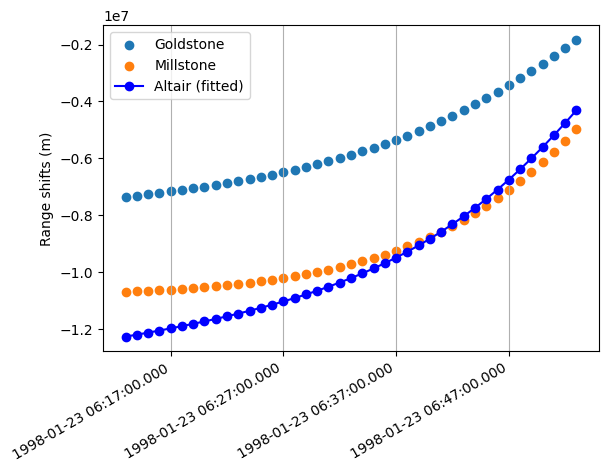

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy import visualization
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel(None)
    plt.ylabel('Range shifts (m)')
    plt.scatter(ssn_epochs[1:], dss25_shifts, label="Goldstone")
    plt.scatter(ssn_epochs[1:], millstone_shifts, label="Millstone")
    plt.plot(ssn_epochs[1:], altair_shifts, 'bo-', label="Altair (fitted)")
    ax.grid(axis='x')
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()

In [22]:
altair_doppler = []
millstone_doppler = []
dss25_doppler = []

for e in ssn_epochs[:-1]:
    ref_rv = near_ssn_ref_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrAltair.range_and_rate(fitter.ephem.rv(e), e)
    altair_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

    ref_r, ref_rr = ssrMillstone.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrMillstone.range_and_rate(fitter.ephem.rv(e), e)
    millstone_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

    ref_r, ref_rr = dss25.range_and_rate(ref_rv, e)
    meas_r, meas_rr = dss25.range_and_rate(fitter.ephem.rv(e), e)
    dss25_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

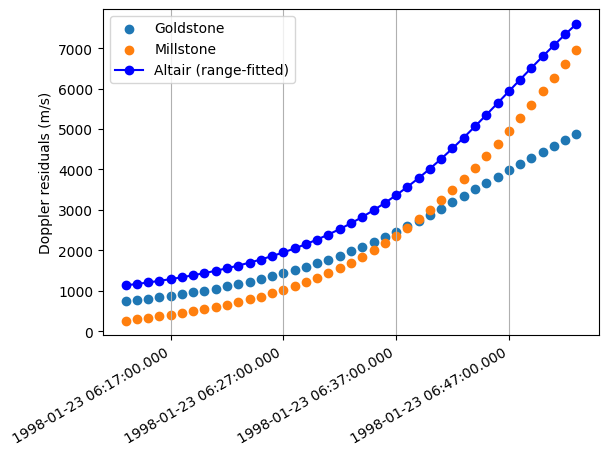

In [23]:
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel(None)
    plt.ylabel('Doppler residuals (m/s)')
    plt.scatter(ssn_epochs[1:], dss25_doppler, label="Goldstone")
    plt.scatter(ssn_epochs[1:], millstone_doppler, label="Millstone")
    plt.plot(ssn_epochs[1:], altair_doppler, 'bo-', label="Altair (range-fitted)")
    ax.grid(axis='x')
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()